In [1]:
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import statistics

import matplotlib.style

import matplotlib

matplotlib.style.use('classic')
import time

In [2]:
import glob,os,sys
os.chdir('C:/Users/yashg/Documents/Cloud_Data_Files')
def read_files(extensions,location):
    l=[]
    for types in extensions:
        l.append(glob.glob(f'./{location}/*{types}'))
    l=[val for sublist in l for val in sublist]
    return l

In [3]:
k=read_files(['.cdf','.nc'],'KAZRARSCL')
m=read_files(['.cdf','.nc'],'Microbase')
r=read_files(['.cdf','.nc'],'Raman Lidar')
s=read_files(['.cdf','.nc'],'Surface')
e=read_files(['.cdf','.nc'],'Ext')
mp=read_files(['.cdf','.nc'],'Micropulse')
master=k+m+r+s+e+mp

In [4]:
day=[]
for x in mp:
    day.append(x[-18:-10])

In [5]:
def date_files(date,master=master):
    f=[]
    for file in master:
        if date in file:
            f.append(file)
    return f

def generate_cdfs(date):
    l=[]
    f=date_files(date)
    for file in f:
        l.append(Dataset(file))
    print('Output has 6 files')
    print('File order is\t1.KAZRARSCL\t2.Microbase\t3.Raman Lidar\t4. Surface\t5. Ext\t6.Micropulse')
    return l

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse


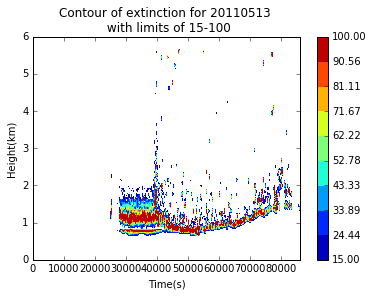

In [15]:
ll=generate_cdfs('20110513')
r1=ll[-2]
tr=r1['time_offset'][:]
hr=r1['height_high'][:]
ex=r1['extinction_merged_bscat'][:]
plt.contourf(tr,hr,ex.T,levels=np.linspace(15,100,10))
plt.colorbar()
plt.xlabel('Time(s)')
plt.ylabel('Height(km)')
plt.ylim(0,6)
plt.title('Contour of extinction for 20110513 \n with limits of 15-100')
plt.show()

In [7]:
for ll in generate_cdfs(day[0]):
    print(ll.variables.keys())
    print('\n')

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
dict_keys(['base_time', 'time_offset', 'time', 'layer', 'height', 'reflectivity_best_estimate', 'qc_reflectivity_best_estimate', 'reflectivity', 'qc_reflectivity', 'mean_doppler_velocity', 'qc_mean_doppler_velocity', 'spectral_width', 'qc_spectral_width', 'linear_depolarization_ratio', 'qc_linear_depolarization_ratio', 'signal_to_noise_ratio', 'reflectivity_clutter_flag', 'mean_doppler_velocity_dealias_flag', 'radar_mode_flag', 'cloud_source_flag', 'precip_mean', 'qc_precip_mean', 'mwr_lwp', 'qc_mwr_lwp', 'radar_first_top', 'cloud_base_best_estimate', 'cloud_layer_base_height', 'cloud_layer_top_height', 'cloud_mask_mplzwang', 'minimum_detectable_reflectivity', 'radar_mode', 'minimum_detectable_reflectivity_flag', 'reflectivity_saturation_flag', 'instrument_availability_flag', 'lat', 'lon', 'alt'])


dict_keys(['base_time', 'time_offset', 'time', 'time_bounds', 'height', 'height_bounds'

In [8]:
k1,m1,r1,s1,e1,mp1=generate_cdfs(day[0])
te=e1['time_offset'][:]
tmp=mp1['time_offset'][:]
he=e1['height_high'][:]
hmp=mp1['height'][:]
ext_e=e1['extinction_merged_bscat'][:]
ext_mp=mp1['backscatter'][:]*18.8

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse


In [9]:
def extinction(ext,t1,h1,threshold=50,upper=100):
    base_h=np.zeros(len(t1))
    extin_h=np.zeros(len(t1))
    upper_extin=np.zeros(len(t1))
    lower_extin=np.zeros(len(t1))
    ht=np.zeros(len(t1))
    for i in range(len(ext)):
        em=ext[i]
        for k,j in enumerate(em):
            if k==0:
                if j>threshold and j<upper and ht[i]>=0:
                    base_h[i]=k
                    extin_h[i]=j
                    ht[i]=h1[k]
                    break
            elif k==len(em)-1:
                if j>threshold and j<upper and j>em[k-1] and ht[i]>=0:
                    base_h[i]=k
                    extin_h[i]=j
                    ht[i]=h1[k]
                    break
            else:
                if j>threshold and j<upper and j>em[k-1] and j<em[k+1] and ht[i]>=0:
                    base_h[i]=k
                    extin_h[i]=j
                    ht[i]=h1[k]
                    lower_extin[i]=em[k-1]
                    upper_extin[i]=em[k+1]
                    break
    return base_h,lower_extin,extin_h,upper_extin,ht

In [10]:
base_h_e,lower_extin_e,extin_h_e,upper_extin_e,ht_e=extinction(ext_e,te,he,threshold=50,upper=100)
base_h_mp,lower_extin_mp,extin_h_mp,upper_extin_mp,ht_mp=extinction(ext_mp,tmp,hmp,threshold=50,upper=100)s

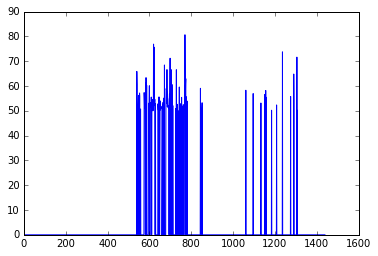

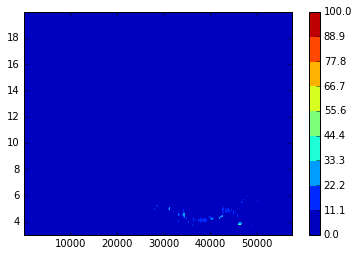

In [11]:
plt.plot(extin_h_e)
plt.show()
plt.contourf(tmp,hmp,ext_mp.T,levels=np.linspace(0,100,10))
plt.ylim(3)
plt.colorbar()
plt.show()

In [12]:
def st_clustering(t1,h1,t2,h2,flag):
    """
    flag=0: Only temporal clustering
    flag=1: Only height clustering
    flag=2: Both
    """
    t_clust=[]
    h_clust=[]
    if flag==2:
        print('--------Start of spatial-temporal clustering cycle--------')
        print(f'Changing time resolution from {len(t2)}->{len(t1)}')
        print(f'Changing height resolution from {len(h2)}->{len(h1)}')
        if len(t1)>len(t2):
            print('You are increasing time resolution')
            for i in t1:
                x=np.argmin(np.abs(i-t2))
                t_clust.append(x)
        else:
            print('You are decreasing time resolution')
            for i in range(len(t1)):
                if i!=len(t1)-1:
                    ltemp=[m for m,x in enumerate(t2) if t1[i]<= x <=t1[i+1]]
                    t_clust.append(ltemp)
                else:
                    ltemp=[m for m,x in enumerate(t2) if t1[i]<= x]
                    t_clust.append(ltemp) 
        if len(h1)>len(h2):
            print('You are increasing height resolution')
            for i in h1:
                x=np.argmin(np.abs(i-h2))
                h_clust.append(x)
        else:
            print('You are decreasing height resolution')     
            for i in range(len(h1)):
                if i!=len(h1)-1:
                    ltemp=[m for m,x in enumerate(h2) if h1[i]<= x <=h1[i+1]]
                    h_clust.append(ltemp)
                else:
                    ltemp=[m for m,x in enumerate(h2) if h1[i]<= x]
                    h_clust.append(ltemp) 
    elif flag==0:
        print('--------Start of temporal clustering cycle--------')
        print(f'Changing time resolution from {len(t2)}->{len(t1)}') 
        if len(t1)>len(t2):
            print('You are increasing time resolution')
            for i in t1:
                x=np.argmin(np.abs(i-t2))
                t_clust.append(x)
        else:
            print('You are decreasing time resolution')
            for i in range(len(t1)):
                if i!=len(t1)-1:
                    ltemp=[m for m,x in enumerate(t2) if t1[i]<= x <=t1[i+1]]
                    t_clust.append(ltemp)
                else:
                    ltemp=[m for m,x in enumerate(t2) if t1[i]<= x]
                    t_clust.append(ltemp) 
    elif flag==1:
        print('--------Start of spatial clustering cycle--------')
        print(f'Changing height resolution from {len(h2)}->{len(h1)}')   
        if len(h1)>len(h2):
            print('You are increasing height resolution')
            for i in h1:
                x=np.argmin(np.abs(i-h2))
                h_clust.append(x)
        else:
            print('You are decreasing height resolution')     
            for i in range(len(h1)):
                if i!=len(h1)-1:
                    ltemp=[m for m,x in enumerate(h2) if h1[i]<= x <=h1[i+1]]
                    h_clust.append(ltemp)
                else:
                    ltemp=[m for m,x in enumerate(h2) if h1[i]<= x]
                    h_clust.append(ltemp)         
    print('--------End of clustering cycle--------')
    return t_clust,h_clust

In [13]:
tclust,dummy=st_clustering(tmp,hmp,te,he,0)

--------Start of temporal clustering cycle--------
Changing time resolution from 1440->1920
You are increasing time resolution
--------End of clustering cycle--------


In [14]:
def reshaping(targs,val):
    if type(targs[0])==list:
        val_red=[]
        for x in targs:
            v=[val[int(i)] for i in x]
            val_red.append(np.mean(v))
    elif type(targs[0])!=list:
        val_red=[]
        for x in targs:
            v=[val[int(x)]]
            val_red.append(np.mean(v))        
    return val_red

In [15]:
ext_e_red=reshaping(tclust,extin_h_e)

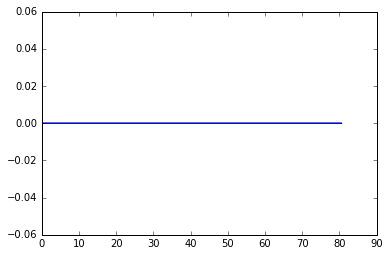

In [16]:
plt.plot(ext_e_red,extin_h_mp)

(array([   0.,    0.,    0.,    0.,    0., 1920.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

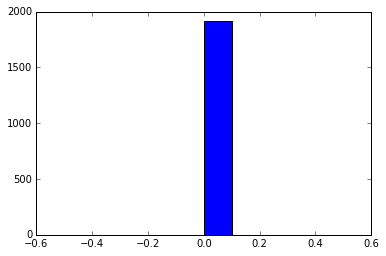

In [17]:
plt.hist(extin_h_mp)

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of temporal clustering cycle--------
Changing time resolution from 960->1920
You are increasing time resolution
--------End of clustering cycle--------


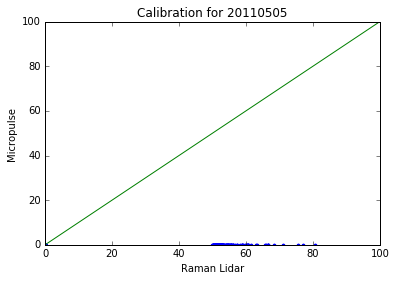

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of temporal clustering cycle--------
Changing time resolution from 540->1080
You are increasing time resolution
--------End of clustering cycle--------


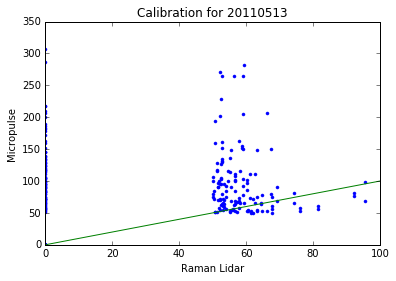

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of temporal clustering cycle--------
Changing time resolution from 1140->2280
You are increasing time resolution
--------End of clustering cycle--------


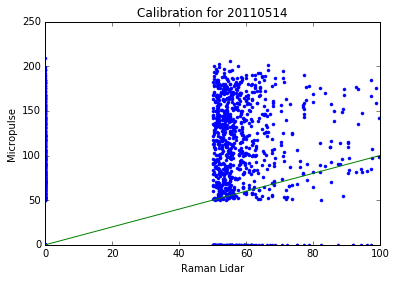

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of temporal clustering cycle--------
Changing time resolution from 60->120
You are increasing time resolution
--------End of clustering cycle--------


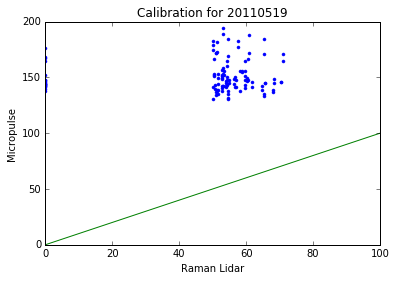

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of temporal clustering cycle--------
Changing time resolution from 1440->2880
You are increasing time resolution
--------End of clustering cycle--------


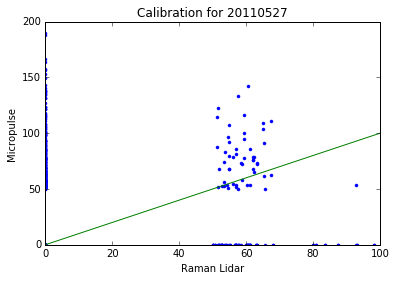

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of temporal clustering cycle--------
Changing time resolution from 1440->2880
You are increasing time resolution
--------End of clustering cycle--------


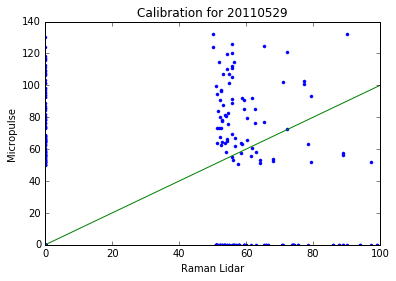

In [18]:
for dat in day:
    k1,m1,r1,s1,e1,mp1=generate_cdfs(dat)
    te=e1['time_offset'][:]
    tmp=mp1['time_offset'][:]
    he=e1['height_high'][:]
    hmp=mp1['height'][:]
    xy=np.where(te<=tmp[-1])[0]
    te_2=te[xy]
    ext_e=e1['extinction_merged_bscat'][:]
    ext_e2=ext_e[xy][:]
    ext_mp=mp1['backscatter'][:]*18.8    
    base_h_e,lower_extin_e,extin_h_e,upper_extin_e,ht_e=extinction(ext_e2,te_2,he,threshold=50,upper=100)
    base_h_mp,lower_extin_mp,extin_h_mp,upper_extin_mp,ht_mp=extinction(ext_mp,tmp,hmp,threshold=50,upper=1000)    
    tclust,dummy=st_clustering(tmp,hmp,te_2,he,0)
    mm=[0,10,20,50,100]
    ext_e_red=reshaping(tclust,extin_h_e)
    plt.plot(ext_e_red,extin_h_mp,'.')
    plt.plot(mm,mm,'-')
    plt.xlabel('Raman Lidar')
    plt.ylabel('Micropulse')
    plt.title(f'Calibration for {dat}')
#    plt.savefig(f'C:/Users/yashg/Documents/Cloud_Data_Files/plots/calibrated_extinction/{dat}_calibrated_ht')
    plt.show()

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse


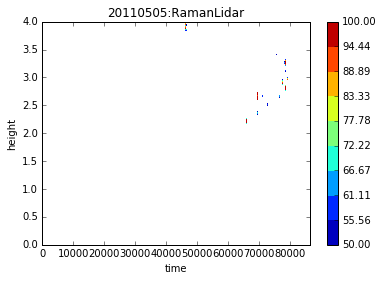

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse


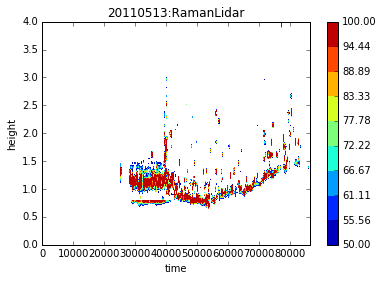

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse


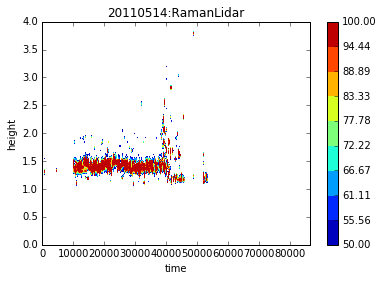

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse


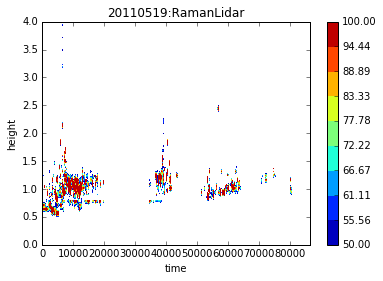

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse


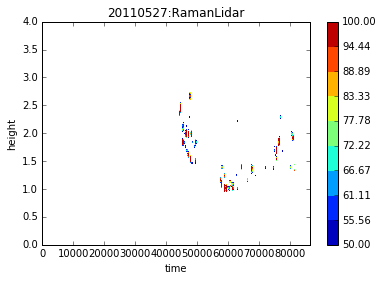

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse


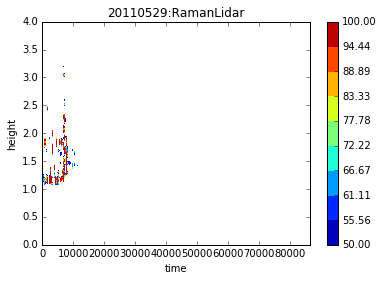

In [55]:
el=[]
mpl=[]
for dat in day:
    k1,m1,r1,s1,e1,mp1=generate_cdfs(dat)
    te=e1['time_offset'][:]
    tmp=mp1['time_offset'][:]
    he=e1['height_high'][:]
    hmp=mp1['height'][:]
    el.append(te[-1])
    mpl.append(tmp[-1])
    ext_e=e1['extinction_merged_bscat'][:]
    ext_mp=mp1['backscatter'][:]*18.8    
    plt.contourf(te,he,ext_e.T,levels=np.linspace(50,100,10))
    plt.title(dat+':RamanLidar')
    plt.xlabel('time')
    plt.ylabel('height')
    plt.colorbar()
    plt.ylim(0,4)
    plt.savefig(f'C:/Users/yashg/Documents/Cloud_Data_Files/plots/raman_contours/{dat}')
    plt.show()

In [67]:
k1,m1,r1,s1,e1,mp1=generate_cdfs(day[0])
te=e1['time_offset'][:]
tmp=mp1['time_offset'][:]
he=e1['height_high'][:]
hmp=mp1['height'][:]
xy=np.where(te<=tmp[-1])[0]
te_2=te[xy]
ext_e=e1['extinction_merged_bscat'][:]
ext_e2=ext_e[xy][:]
ext_mp=mp1['backscatter'][:]*18.8   
base_h_e,lower_extin_e,extin_h_e,upper_extin_e,ht_e=extinction(ext_e2,te_2,he,threshold=50,upper=100)
base_h_mp,lower_extin_mp,extin_h_mp,upper_extin_mp,ht_mp=extinction(ext_mp,tmp,hmp,threshold=50,upper=100)    
tclust,dummy=st_clustering(tmp,hmp,te_2,he,0)
ext_e_red=reshaping(tclust,extin_h_e)

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
--------Start of temporal clustering cycle--------
Changing time resolution from 960->1920
You are increasing time resolution
--------End of clustering cycle--------


In [78]:
for dat in day:
    k1,m1,r1,s1,e1,mp1=generate_cdfs(dat)
    t=mp1['time'][:]
    print(t.shape)

Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
(1920,)
Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
(1080,)
Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
(2280,)
Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
(120,)
Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
(2880,)
Output has 6 files
File order is	1.KAZRARSCL	2.Microbase	3.Raman Lidar	4. Surface	5. Ext	6.Micropulse
(2880,)
